In [45]:
using ChaosTools, DynamicalSystems, StaticArrays

using Base.Threads

function spinonly_ode(u, p, t)
    s1x, s2x, s1y, s2y, s1z, s2z = u
    Δ1, Δ2, Δ, g, φ, κ, η = p
    # Derived parameters
    K = κ / 2
    Δ_plus = Δ * cos(φ) + K * sin(φ)
    Δ_minus = Δ * cos(φ) - K * sin(φ)
    K_plus = K * cos(φ) + Δ * sin(φ)
    K_minus = K * cos(φ) - Δ * sin(φ)
    𝒥 = g^2 / (Δ^2 + K^2)  # 𝒥 = g²/(Δ² + (κ/2)²)

    # Equations for s1x, s2x, s1y, s2y
    du1 = Δ1 * s1y + s1z * 𝒥 * (Δ * s1y + K * s1x + K_plus * s2x + Δ_plus * s2y - 2 * K * η / g)
    du2 = Δ2 * s2y + s2z * 𝒥 * (Δ * s2y + K * s2x + K_minus * s1x + Δ_plus * s1y - 2 * K_minus * η / g)
    du3 = -Δ1 * s1x + s1z * 𝒥 * (-Δ * s1x + K * s1y - Δ_minus * s2x + K_plus * s2y + 2 * Δ * η / g)
    du4 = -Δ2 * s2x + s2z * 𝒥 * (-Δ * s2x + K * s2y - Δ_plus * s1x + K_minus * s1y + 2 * Δ_plus * η / g)

    # Equations for s1z, s2z
    du5 = -𝒥 * (
        -2 * η / g * (K * s1x - Δ * s1y) +
        K * (s1x^2 + s1y^2) +
        K_plus * s1x * s2x +
        Δ_plus * s1x * s2y -
        Δ_minus * s1y * s2x +
        K_plus * s1y * s2y
    )

    du6 = -𝒥 * (
        -2 * η / g * (K_minus * s2x - Δ_plus * s2y) +
        K * (s2x^2 + s2y^2) +
        K_minus * s2x * s1x +
        Δ_plus * s2x * s1y -
        Δ_plus * s2y * s1x +
        K_minus * s2y * s1y
    )

    return SVector{6}(du1, du2, du3, du4, du5, du6)
end

spinonly_ode (generic function with 1 method)

In [52]:
g=0.1
φ_values = range(-pi/2, stop = pi/2, length = 101)
η_values = range(0.0, stop = 2*g, length = 101)
max_lyapunov_array = zeros(length(η_values), length(φ_values))


# Parallelization
ENV["JULIA_NUM_THREADS"] = 20

# Initial condition vector
eps1=0.3
del1=0.15
eps2=-0.1
del2=0.2
u0_B = [eps, eps, del, del, sqrt(1.0-eps^2-del^2), sqrt(1.0-eps^2-del^2)]  


# Computing max_lyapunov_array
@threads for i in 1:length(η_values)
    η = η_values[i]
    for j in 1:length(φ_values)
        φ = φ_values[j]        
        p = [0, 0, 0, g, φ, 1, η] #[Δ1, Δ2, Δ, g, φ, κ, η]

        # Create a CoupledODEs object for Model 
        coup_tc = CoupledODEs(spinonly_ode, u0_B, p)

        # Compute the Lyapunov exponents
        λλ = lyapunovspectrum(coup_tc, 10000; Δt = 0.1)
        
        # Find the maximum Lyapunov exponent
        max_lyapunov = maximum(λλ)
        
        # Store the maximum Lyapunov exponent in the array
        max_lyapunov_array[i, j] = max_lyapunov
    end
end

#save .dat file

using DelimitedFiles
open("data_del_0.dat", "w") do f
    writedlm(f, max_lyapunov_array)
end

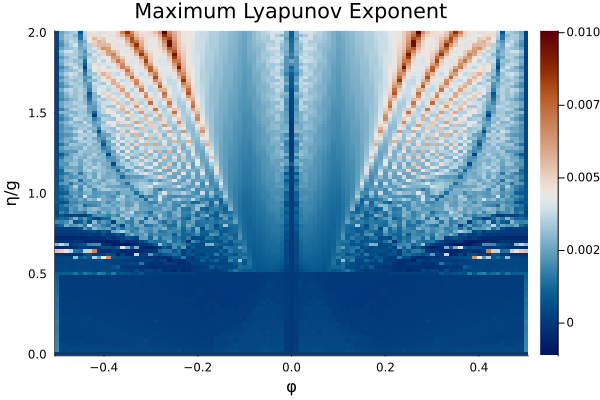

In [50]:
using Plots
heatmap( φ_values/pi, η_values/g, max_lyapunov_array,
    ylabel = "η/g", xlabel = "φ", title = "Maximum Lyapunov Exponent",
    color = :viridis, c = :vik, clim = (minimum(max_lyapunov_array), maximum(max_lyapunov_array)))